In [1]:
import os
import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.spatial.transform import Rotation as R

# ================= 路径配置 =================
# 请修改为你自己的路径
DATA_ROOT = "/home/xzy/datasets/Rellis-3D" 
SEQ = "00004"
FRAME_ID_STR = "000000"  # 字符串形式的帧ID

# 1. 图像路径
IMG_PATH = os.path.join(DATA_ROOT, SEQ, 'pylon_camera_node', f'frame{FRAME_ID_STR}-1581791678_408.jpg') # 注意：这里文件名可能需要根据实际情况修改通配符或具体名称

# 2. 点云路径
BIN_PATH = os.path.join(DATA_ROOT, SEQ, 'os1_cloud_node_kitti_bin', f'{FRAME_ID_STR}.bin')

# 3. 位姿路径 (LiDAR在世界系下的位姿)
POSES_PATH = os.path.join(DATA_ROOT, SEQ, 'poses.txt')

# 4. 标定文件路径 (Camera 到 LiDAR 的外参)
CALIB_PATH = os.path.join(DATA_ROOT, SEQ, 'transforms.yaml')

# 5. 相机内参文件
CALIB_K_PATH = os.path.join(DATA_ROOT, 'Rellis_3D_cam_intrinsic/Rellis-3D', SEQ, 'camera_info.txt')

# 定义畸变系数
distCoeff = np.array([-0.134313, -0.025905, 0.002181, 0.00084, 0])
distCoeff = distCoeff.reshape((5,1))

print("Checking paths:")
print(f"Img: {os.path.exists(IMG_PATH)}")
print(f"Bin: {os.path.exists(BIN_PATH)}")
print(f"Poses: {os.path.exists(POSES_PATH)}")
print(f"Calib: {os.path.exists(CALIB_PATH)}")
print(f"K: {os.path.exists(CALIB_K_PATH)}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Checking paths:
Img: True
Bin: True
Poses: True
Calib: True
K: True


In [3]:
def load_lidar_bin(bin_path):
    """读取二进制点云 (x, y, z, i)"""
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points[:, :3] # 只取 XYZ

def read_poses(filename):
    """读取 poses.txt (T_world_lidar)"""
    poses = []
    with open(filename, 'r') as f:
        for line in f:
            values = [float(v) for v in line.strip().split()]
            pose = np.eye(4)
            pose[:3, :4] = np.array(values).reshape(3, 4)
            poses.append(pose)
    return poses

def get_transform_from_yaml(yaml_path, parent_frame, child_frame):
    """
    解析 ROS 风格的 transforms.yaml
    
    针对类似 Rellis-3D 的变换格式，其中包含多个 frame 变换定义
    格式示例：
    parent_frame-child_frame:
      q: {w: 0.5, x: 0.5, y: 0.5, z: 0.5}
      t: {x: 1.0, y: 2.0, z: 3.0}
    
    返回 4x4 矩阵 T_parent_child
    """
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    
    # 方法1: 尝试使用提供的 frame 名称组合作为键
    frame_key = f"{parent_frame}-{child_frame}"
    if frame_key in data:
        transform_data = data[frame_key]
    else:
        # 方法2: 查找包含指定 frame 名称的键
        matching_keys = [key for key in data.keys() 
                        if parent_frame in key and child_frame in key]
        if not matching_keys:
            print(f"Error: No transform found for {parent_frame}->{child_frame}")
            return np.eye(4)
        # 如果有多个匹配，使用第一个
        frame_key = matching_keys[0]
        transform_data = data[frame_key]
    
    # 解析平移向量
    t_data = transform_data.get('t', {})
    t = np.array([
        t_data.get('x', 0.0),
        t_data.get('y', 0.0), 
        t_data.get('z', 0.0)
    ])
    
    # 解析四元数旋转
    q_data = transform_data.get('q', {})
    # ROS 四元数顺序: (x, y, z, w)
    q = np.array([
        q_data.get('x', 0.0),
        q_data.get('y', 0.0),
        q_data.get('z', 0.0),
        q_data.get('w', 1.0)  # 默认 w=1.0
    ])
    
    # 构建变换矩阵
    T = np.eye(4)
    if np.linalg.norm(q) > 0:  # 检查四元数是否有效
        q = q / np.linalg.norm(q)  # 归一化
        R_mat = R.from_quat(q).as_matrix()
        T[:3, :3] = R_mat
    T[:3, 3] = t
    
    print(f"Loaded transform {frame_key}: t={t}, q={q}")
    return T

# ================= 相机内参 (Intrinsics) =================
# Rellis-3D 的相机内参通常不包含在 transforms.yaml 中，而是单独的 camera_info
# 如果你没有内参文件，这里提供一个 Rellis-3D 常用的近似值 (需根据实际情况微调)
# 假设图片分辨率是 1920 x 1200 或类似
def get_camera_intrinsics(calib_k_path):
    """
    从相机内参文件读取内参矩阵 K
    
    参数:
        calib_k_path: 内参文件路径，文件内容格式为 "fx fy cx cy"
    
    返回:
        K: 3x3 相机内参矩阵
    """
    with open(calib_k_path, 'r') as f:
        # 读取一行，按空格分割
        fx, fy, cx, cy = map(float, f.readline().strip().split())
    
    K = np.array([
        [fx, 0.0, cx],
        [0.0, fy, cy],
        [0.0, 0.0, 1.0]
    ])
    
    return K

K = get_camera_intrinsics(CALIB_K_PATH)
print("Using Camera Intrinsics:\n", K)

T_l_c = get_transform_from_yaml(CALIB_PATH, parent_frame='os1_cloud_node', child_frame='pylon_camera_node') 
print("Extrinsic T_lidar_camera:\n", T_l_c)

Using Camera Intrinsics:
 [[2.81364327e+03 0.00000000e+00 9.69285772e+02]
 [0.00000000e+00 2.80832608e+03 6.24049972e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Loaded transform os1_cloud_node-pylon_camera_node: t=[-0.09581321  0.04062246 -0.16507774], q=[ 0.5115674   0.49051429 -0.49270892 -0.50490835]
Extrinsic T_lidar_camera:
 [[ 0.0332673   0.00431654 -0.99943717 -0.09581321]
 [ 0.99940794 -0.00892657  0.03322777  0.04062246]
 [-0.00877812 -0.99995084 -0.00461095 -0.16507774]
 [ 0.          0.          0.          1.        ]]


## 畸变处理测试

蓝绿色表畸变处理前后差异很小的位置。黄色线段表示处理前后的偏移。

>>> Calculating projections...

畸变影响数值分析 (Distortion Analysis)
参与统计点数: 4882
最小位移 (Min Shift): 0.0013 pixels
最大位移 (Max Shift): 23.4403 pixels
平均位移 (Mean Shift): 4.8435 pixels
----------------------------------------
结论: 畸变影响显著，必须使用畸变矫正！



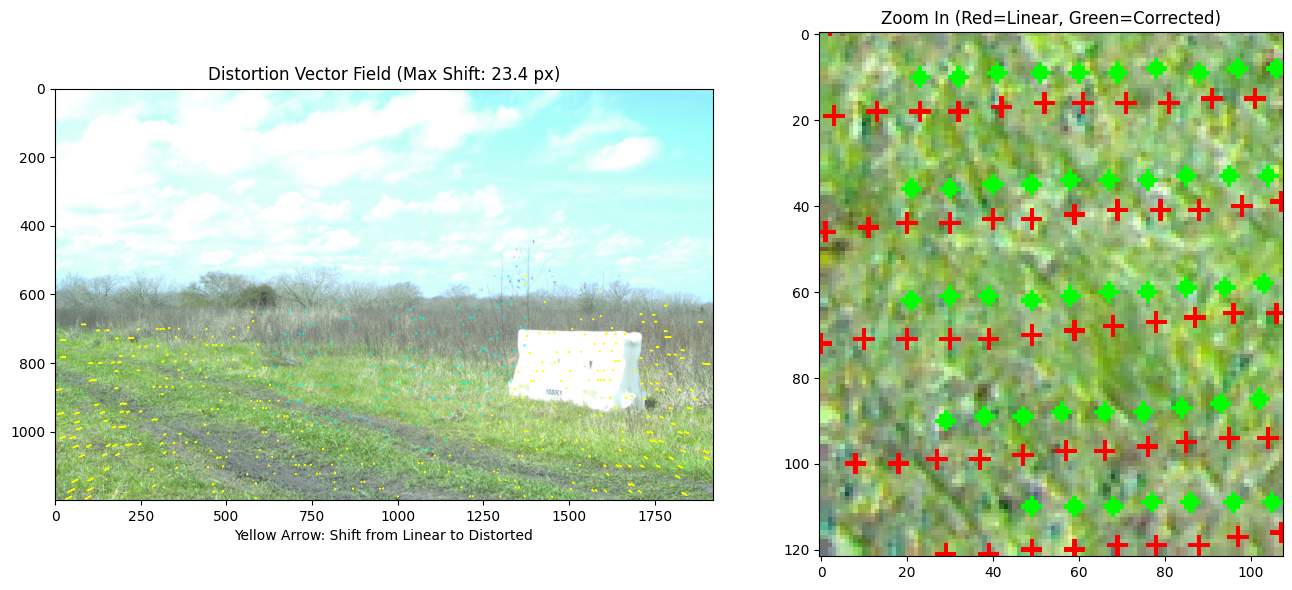

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compare_projection_methods(points_cam, K, dist_coeffs):
    """
    [核心测试函数] 对比线性投影 vs 畸变投影
    输入:
        points_cam: (N, 3) 相机系下的点云 (x, y, z)
        K: (3, 3) 内参矩阵
        dist_coeffs: (5, 1) 畸变系数
    输出:
        uv_linear: (N, 2) 线性投影坐标
        uv_distorted: (N, 2) 畸变校正后坐标
        shifts: (N,) 每个点被移动的像素距离 (欧氏距离)
    """
    # 1. 方法 A: 线性投影 (Linear / Pinhole Model)
    # 公式: p_uv = K * (P_c / z)
    pts_uv_z = K @ points_cam.T # (3, N)
    pts_uv_linear = pts_uv_z / pts_uv_z[2, :] # 除以 Z 归一化
    uv_linear = pts_uv_linear[:2, :].T # (N, 2)

    # 2. 方法 B: OpenCV 畸变投影 (Distorted Model)
    # 必须确保内存连续 + float32，否则 OpenCV 会报错
    object_points = np.ascontiguousarray(points_cam[:, :3], dtype=np.float32)
    rvec = np.zeros((3, 1), dtype=np.float32)
    tvec = np.zeros((3, 1), dtype=np.float32)
    K_32 = np.array(K, dtype=np.float32)
    D_32 = np.array(dist_coeffs, dtype=np.float32)
    
    pts_uv_dist, _ = cv2.projectPoints(object_points, rvec, tvec, K_32, D_32)
    uv_distorted = pts_uv_dist.reshape(-1, 2) # (N, 2)

    # 3. 计算差异 (Shift)
    # diff = sqrt((u1-u2)^2 + (v1-v2)^2)
    diff = uv_linear - uv_distorted
    shifts = np.linalg.norm(diff, axis=1)
    
    return uv_linear, uv_distorted, shifts

def analyze_distortion_impact(bin_path, img_path, T_l_c, K, dist_coeffs):
    """
    [可视化分析] 生成两张图表来证明畸变的作用
    1. 矢量场图 (Quiver Plot): 画出箭头，显示点云是如何被“矫正”移动的。
    2. 图像叠加对比: 红色=线性，绿色=畸变后。
    """
    # --- A. 数据准备 ---
    # 1. 读取并转到相机系 (复用之前的逻辑，但不进行投影)
    points_3d = load_lidar_bin(bin_path)
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    
    T_c_l = np.linalg.inv(T_l_c)
    points_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    points_cam = (T_c_l @ points_h.T).T # (N, 4)
    points_cam = points_cam[points_cam[:, 2] > 0] # Z > 0
    points_cam = points_cam[:, :3] # 去掉齐次项

    if len(points_cam) == 0:
        print("No points found.")
        return

    # --- B. 运行核心对比 ---
    print(">>> Calculating projections...")
    uv_lin, uv_dist, shifts = compare_projection_methods(points_cam, K, dist_coeffs)
    
    # 过滤掉图像外的点 (以线性投影为准，方便对比)
    u, v = uv_lin[:, 0], uv_lin[:, 1]
    mask_fov = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    
    uv_lin_fov = uv_lin[mask_fov]
    uv_dist_fov = uv_dist[mask_fov]
    shifts_fov = shifts[mask_fov]
    
    # --- C. 数值统计 ---
    print("\n" + "="*40)
    print("畸变影响数值分析 (Distortion Analysis)")
    print("="*40)
    print(f"参与统计点数: {len(shifts_fov)}")
    print(f"最小位移 (Min Shift): {np.min(shifts_fov):.4f} pixels")
    print(f"最大位移 (Max Shift): {np.max(shifts_fov):.4f} pixels")
    print(f"平均位移 (Mean Shift): {np.mean(shifts_fov):.4f} pixels")
    print("-" * 40)
    if np.mean(shifts_fov) < 0.5:
        print("结论: 畸变非常微小，几乎可以忽略 (Linear ≈ Distorted)")
    else:
        print("结论: 畸变影响显著，必须使用畸变矫正！")
    print("="*40 + "\n")

    # --- D. 可视化 1: 矢量场 (夸张显示) ---
    # 我们随机采样 500 个点来画箭头，否则太密集看不清
    if len(uv_lin_fov) > 500:
        idx = np.random.choice(len(uv_lin_fov), 500, replace=False)
    else:
        idx = np.arange(len(uv_lin_fov))
        
    plt.figure(figsize=(14, 6))
    
    # 子图 1: 矢量场 (Quiver)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Distortion Vector Field (Max Shift: {np.max(shifts_fov):.1f} px)")
    
    # 画箭头: 起点=线性(红), 终点=畸变(绿)
    # 箭头的方向代表畸变矫正“把点搬运到了哪里”
    # scale_units='xy', angles='xy', scale=1 保证箭头长度对应真实像素距离
    # 为了让箭头更明显，可以把 scale 设小一点，或者手动放大 diff
    
    # 这里我们只画线段连接: Red Dot -> Green Dot
    for i in idx:
        pt1 = uv_lin_fov[i]   # Linear (Origin)
        pt2 = uv_dist_fov[i]  # Distorted (Target)
        
        # 如果位移太小(<1px)，就不画线了，只画点
        if shifts_fov[i] > 1.0:
            plt.arrow(pt1[0], pt1[1], pt2[0]-pt1[0], pt2[1]-pt1[1], 
                      color='yellow', width=0.5, head_width=2, length_includes_head=True)
        else:
            plt.scatter(pt1[0], pt1[1], s=1, c='cyan', alpha=0.5)

    plt.xlabel("Yellow Arrow: Shift from Linear to Distorted")

    # 子图 2: 具体的对比 (Zoom In 效果)
    # 我们选择位移最大的那个区域放大看
    max_idx = np.argmax(shifts_fov)
    center_u, center_v = uv_lin_fov[max_idx]
    zoom_size = 100 # 200x200 的窗口
    
    plt.subplot(1, 2, 2)
    img_viz = img.copy()
    
    # 在原图上画圈: 红色=Linear, 绿色=Distorted
    # 画所有点（不仅仅是采样点）
    for i in range(len(uv_lin_fov)):
        # 红色 x = 线性
        cv2.drawMarker(img_viz, (int(uv_lin_fov[i][0]), int(uv_lin_fov[i][1])), 
                       (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1)
        # 绿色 o = 畸变后
        cv2.circle(img_viz, (int(uv_dist_fov[i][0]), int(uv_dist_fov[i][1])), 
                   2, (0, 255, 0), -1)

    # 裁剪局部
    u_min = max(0, int(center_u - zoom_size))
    u_max = min(w, int(center_u + zoom_size))
    v_min = max(0, int(center_v - zoom_size))
    v_max = min(h, int(center_v + zoom_size))
    
    crop = img_viz[v_min:v_max, u_min:u_max]
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title("Zoom In (Red=Linear, Green=Corrected)")
    
    plt.tight_layout()
    plt.show()

# ================= 调用测试 =================
# 这里的 distCoeff 来自你之前提供的数据
distCoeff = np.array([-0.134313,-0.025905,0.002181,0.00084,0]).reshape((5,1))

analyze_distortion_impact(BIN_PATH, IMG_PATH, T_l_c, K, distCoeff)

## 处理畸变后的显示

>>> Raw Point Cloud Statistics (In FOV):
Dimension  Min          Max          Mean         Std         
------------------------------------------------------------
X (Right)  -19.7992     20.7021      -0.1244      3.8342      
Y (Down)   -0.8471      1.1835       0.9051       0.2851      
Z (Fwd)    1.6240       37.6280      10.0274      5.8743      
Dist       3.6597       39.4564      10.9605      5.5264      

>>> Applying Filters:
  Filter 1: z in [9.0, 12.0] -> Remaining points: 1141


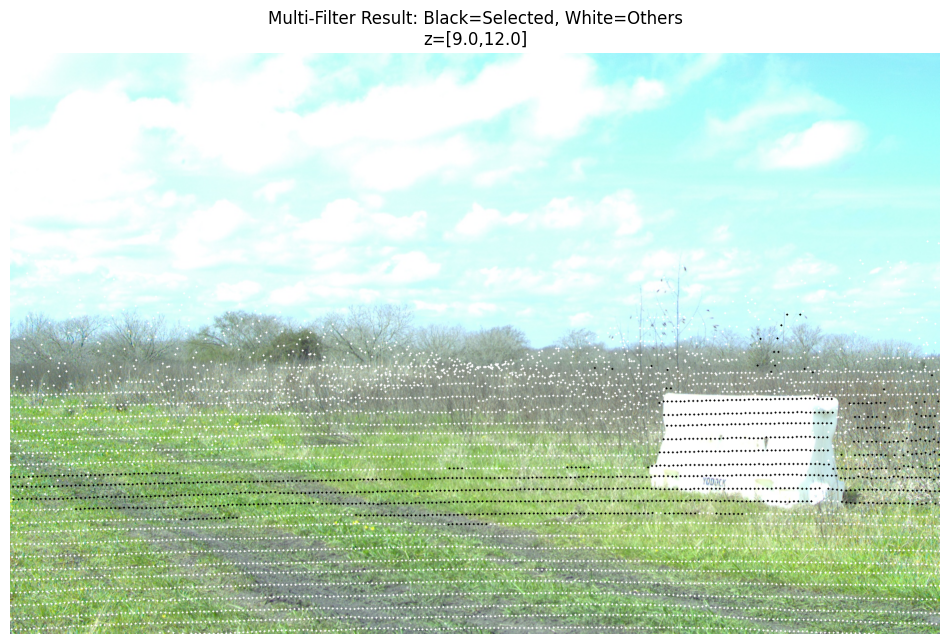

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_cam_points_in_uv(bin_path, img_path, T_l_c, K, dist_coeffs=None):
    """
    [辅助函数] 读取数据 -> 转换到相机系 -> 投影(含畸变) -> 过滤
    
    新增参数:
        dist_coeffs: (5, 1) or (N,) numpy array, 畸变系数 [k1, k2, p1, p2, k3]
    """
    # 1. 读取
    points_3d = load_lidar_bin(bin_path) # (N, 3) 原始雷达系
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Cannot read image {img_path}")
    h, w = img.shape[:2]
    
    # 2. 变换
    T_c_l = np.linalg.inv(T_l_c)
    points_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    points_cam = (T_c_l @ points_h.T).T # (N, 4)
    
    # 3. 过滤 Z > 0
    mask_z = points_cam[:, 2] > 0
    points_cam = points_cam[mask_z]
    
    if len(points_cam) == 0:
        return np.array([]), np.array([]), img

    # 4. 投影 (关键修改部分)
    if dist_coeffs is not None:
        # 使用 cv2.projectPoints 处理透视和畸变
        # 因为点已经转换到了相机坐标系(points_cam)，所以这里的 rvec 和 tvec 设为 0
        object_points = np.ascontiguousarray(points_cam[:, :3], dtype=np.float32)
        rvec = np.zeros((3, 1))
        tvec = np.zeros((3, 1))
        
        # input: (N, 3) object points, output: (N, 1, 2) image points
        pts_uv_distorted, _ = cv2.projectPoints(object_points, rvec, tvec, K, dist_coeffs)
        pts_uv = pts_uv_distorted.reshape(-1, 2) # (N, 2) -> u, v
    else:
        # 旧的线性投影 (假设无畸变)
        pts_uv_z = K @ points_cam[:, :3].T
        pts_uv = pts_uv_z / pts_uv_z[2, :]
        pts_uv = pts_uv.T # (N, 2)
    
    # 5. 过滤图像边界
    u, v = pts_uv[:, 0], pts_uv[:, 1]
    mask_img = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    
    points_cam_valid = points_cam[mask_img]
    uv_valid = pts_uv[mask_img, :2] # 只取 u, v
    
    return points_cam_valid, uv_valid, img

def print_points_stats(points_cam):
    """
    [需求1] 统计并打印相机系下 x, y, z, distance 的相关信息
    """
    if len(points_cam) == 0:
        print("No points to calculate statistics.")
        return

    x = points_cam[:, 0]
    y = points_cam[:, 1]
    z = points_cam[:, 2]
    dist = np.linalg.norm(points_cam[:, :3], axis=1) # 欧氏距离
    
    print("=" * 60)
    print(f"{'Dimension':<10} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12}")
    print("-" * 60)
    
    metrics = {
        'X (Right)': x,
        'Y (Down)': y,
        'Z (Fwd)': z,
        'Dist': dist
    }
    
    for name, data in metrics.items():
        print(f"{name:<10} {np.min(data):<12.4f} {np.max(data):<12.4f} {np.mean(data):<12.4f} {np.std(data):<12.4f}")
    print("=" * 60)

def get_mask_by_range(points_cam, axis_name, v_min, v_max):
    """
    [需求2] 输入维度和范围，返回选中点的 Mask
    axis_name: 'x', 'y', 'z', 'dist'
    """
    if axis_name == 'x':
        vals = points_cam[:, 0]
    elif axis_name == 'y':
        vals = points_cam[:, 1]
    elif axis_name == 'z':
        vals = points_cam[:, 2]
    elif axis_name == 'dist':
        vals = np.linalg.norm(points_cam[:, :3], axis=1)
    else:
        raise ValueError(f"Unknown axis: {axis_name}")
    
    # 生成掩码：在范围内为 True
    mask = (vals >= v_min) & (vals <= v_max)
    return mask

def visualize_multi_filters(bin_path, img_path, T_l_c, K, filters_list):
    """
    [需求3] 多次筛选并可视化
    filters_list: 列表，每个元素为元组 (axis_name, min_val, max_val)
                  例如: [('dist', 5, 20), ('y', -1, 1)]
    可视化逻辑:
        - 满足所有条件的点 (Selected): 黑色
        - 不满足的点 (Unselected): 白色
    """
    # 1. 获取基础数据
    points_cam, uv, img = get_cam_points_in_uv(BIN_PATH, IMG_PATH, T_l_c, K, dist_coeffs=distCoeff)
    
    if len(points_cam) == 0:
        print("No points in FOV.")
        return

    # 2. 打印基础统计信息 (方便用户决定筛选范围)
    print(">>> Raw Point Cloud Statistics (In FOV):")
    print_points_stats(points_cam)
    
    # 3. 逐个应用筛选器
    # 初始状态：所有点都选中
    final_mask = np.ones(len(points_cam), dtype=bool)
    
    print("\n>>> Applying Filters:")
    for i, (axis, v_min, v_max) in enumerate(filters_list):
        # 调用 [需求2] 的函数
        mask = get_mask_by_range(points_cam, axis, v_min, v_max)
        
        # 取交集 (AND)
        final_mask = final_mask & mask
        
        curr_count = np.sum(final_mask)
        print(f"  Filter {i+1}: {axis} in [{v_min}, {v_max}] -> Remaining points: {curr_count}")

    # 4. 绘图
    img_viz = img.copy()
    
    u = uv[:, 0]
    v = uv[:, 1]
    
    # 颜色定义 (BGR)
    color_selected = (0, 0, 0)       # 黑色
    color_unselected = (255, 255, 255) # 白色
    
    # 绘制
    # 建议先画未选中的(白)，再画选中的(黑)，以防遮挡
    # 分离索引
    idx_selected = np.where(final_mask)[0]
    idx_unselected = np.where(~final_mask)[0]
    
    # 画未选中的 (白点)
    for i in idx_unselected:
        cv2.circle(img_viz, (int(u[i]), int(v[i])), radius=2, color=color_unselected, thickness=-1)
        
    # 画选中的 (黑点)
    for i in idx_selected:
        cv2.circle(img_viz, (int(u[i]), int(v[i])), radius=2, color=color_selected, thickness=-1)
        
    # 5. 显示
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_viz, cv2.COLOR_BGR2RGB))
    
    # 生成标题
    title_str = "Multi-Filter Result: Black=Selected, White=Others\n"
    filter_strs = [f"{a}=[{l},{h}]" for a, l, h in filters_list]
    title_str += " & ".join(filter_strs)
    
    plt.title(title_str)
    plt.axis('off')
    plt.show()

# ==========================================
# 示例调用
# ==========================================

# 定义筛选条件列表
# 例子逻辑：
# 1. 距离 (dist) 在 5米 到 30米 之间
# 2. 高度 (y) 在 -1.5米 到 1.0米 之间 (去除地面和天空)
my_filters = [
    # ('dist', 5.0, 10.0),
    # ('y', 0.5, 2.0),
    # ('x', 1.5, 4.0),
    ('z', 9.0, 12.0),
]

# 运行
visualize_multi_filters(BIN_PATH, IMG_PATH, T_l_c, K, my_filters)